<img src="media/TubLogo.png" alt="Drawing" align="right" style="width: 150px;"/>

````
Seminar:    Adaptive Filter, SoSe 2018, 
            NUE, Institut für Telekommunikationssysteme, TU Berlin
Betreuung:  M.Sc. Liven Lange, Prof. Dr.-Ing. Sikora

Eingereicht von Maximilian Weber (385153)
```

# Softwareaufgabe Systemidentifikation
<img src="media/SimAufgabe.png" alt="Drawing" style="width: 800px;"/>

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import tools as ts

# import data as dictionary
importMat, fileNames = ts.importmat('./data/')

*** Toolbox succesfully loaded.
*** Importing files from directory: ./data/
* importing: System_FIR27.mat
* importing: System_IIR27.mat
* importing: Systemwechsel_FIR27.mat
* importing: Systemwechsel_IIR27.mat
* importing: Test.mat
* importing: Training.mat
*** 6 files imported


## Vorbereitungsaufgabe
Erstelle ein empfängerseitiges adaptives FIR Filter mit $N$ Koeffizienten, dass anhand des empfangenen Signals $d[k]$ eine Systemidentifikation durchführt. Implementiere eigenständig sowohl den LMS als auch den RLS als Lernalgorithmus.

<img src="media/SimSetup.png" alt="Drawing" style="width: 800px;"/>

In [2]:
# import algorithms (see python/algorithms.py)
import algorithms as algo

*** Algorithms succesfully loaded.


## Aufgabe 1: FIR Systemidentifikation via LMS Algorithmus
Für das FIR-Filter: Untersuche den Einfluss der Anzahl an Filterkoeffizienten $N \in \{1, 2, 5\}$, der Wahl des Lernalgorithmus (LMS, RLS) sowie den Einfluss der Varianz des AWGNS ($\sigma^2 \in \{0.001, 0.1, 1, 10\}$). Wähle sinnvolle Kombinationen um die Einflüsse gut beschreiben zu können. Dokumentiere dazu die Filtergewichte und Fehlerwerte je Iteration. Vergleiche LMS und RLS miteinander und beschreibe jeweilige Vorzüge und Nachtteile.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


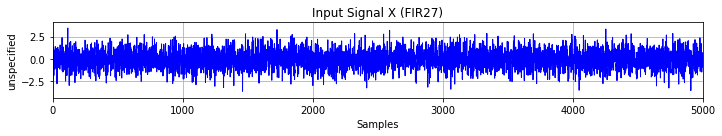

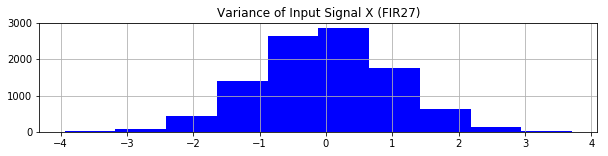

In [3]:
# load FIR data from dictionary
HfirD = importMat['System_FIR27']['D_']
HfirX = importMat['System_FIR27']['X']

# check input signal variance and plot
ts.plot(HfirX,'Input Signal X (FIR27)','lin',5000)
ts.hist(HfirX,'Variance of Input Signal X (FIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))
#print('Eigenvalue Spread of X:', ts.eigSpread(HfirX,1000))

#### Aufgabe 1: Systemidentifikation eines FIR Systems mit variablem AWGNS


Zunächst werden wie in _Aufgabe 1_ verlangt alle Filtergewichte und Fehlerwerte je Iteration von der implementierten LMS Funktion gespeichter und somit automatisch dokumentiert. Es lassen sich außerdem die Anzahl der Filtertaps $N$, die Schrittweite $\mu$ und die Rauschvarianz $\sigma^2$ in den Funktionsaufrufen und durch die print returns der Python Konsole ablesen. 

Der mittlere quadratische Fehler (engl. Mean-Squared Error bzw. MSE) wird im folgenden im oberen Subplot als Lernkurve pro Iteration in Samples aufgetragen. 
Ein gegen 0 konvergierender Verlauf ist hier optimal, denn so zeigt sich das der Fehler zwischen dem gewünschten Signal und dem Ausgang des Filters geringer wird und das sich somit auch das Filterverhalten durch den Algorithmus verbessert.

Der untere Subplot visualisiert die jeweiligen Filtergewichte für jede Iteration. Eine Konvergenz zu einem fixen Wert für jeden Filtertap ist hier erwünscht und zeigt das das sich der Filter zunehmend auf ein Optimum zubewegt.


**Die Anzahl der Filtertaps $N$** bezeichnet die Anzahl der zur Verfügung stehenden Filterkoeffizienten des RLS- und LMS Algorithmus bzw. Delay-Taps des adaptiven FIR-Filters. Im Zusammenhang mit dem KLMS bezieht sich diese Größe analog zu den Koeffizienten auf die Anzahl zurückliegender Werte (Delay Taps), welche für die Prädiktion in Betracht gezogen werden.

Am Rande: Laut Vorlesung muss die Anzahl der Taps für den KLMS selbst bei non-linearen, chaotischen System nich sonderlich hoch gewählt werden. Selbst eine Anzahl von unter 10 Koeffizienten zeigt annähernd das optimale Verhalten bei der Prädiktion des Systemverhaltens wie bspw. der *Mackey-Glass time-series* [2, p.55].


**Die Schrittweite (des LMS) $\mu$** beeinflusst wie stark der Fehler $e[n] = d[n] - y[n]$ die Adaption des Filters für jede Iteration gewichtet. Ein großes $\mu$ erhöht dabei die Geschwindigkeit der Adaption, kann aber auch zu sehr "nervösem" Verhalten der Adaption führen und eine Konvergenz ins Fehlerminimum durch ständiges Über- und Unterschreiten der Optimalgewichtung bzw. dem zu erreichenden Minimalfehlers $J_{min}$  unmöglich machen. Eine klein gewählte Schrittweite vermeidet starkes Über - und Unterschreiten des Optimums. Die Adaption dauert aber entsprechend länger um sich in die Nähe des zu erreichenden Optimums zu bewegen.

In der Praxis werden aufgrund dieser Abwägung der Schrittweite häufig adaptive Schrittweiten verwendet, welche $\mu$ je nach Tendenz und Entwicklung des MSE größer oder kleiner werden lässt. Bsp: Vergrößert sich der MSE über mehrere Iterationen - bewegt sich der Filter also möglicherweise weg vom Optimum so kann es sinnvoll sein die Schrittweite zu vergrößern. Vermindert sich der MSE hingegen über mehrere Iterationen so kann angenommen werden, dass sich das Filter auf das Optimum zubewegt und es kann eine zunehmend kleinere Schrittweite gewählt werden.


**Der Vergessensfaktor (des RLS) $\rho$** lässt sich in der vorliegenden Implementierung durch das Argument `memleak` $= -\rho + 1$ einstellen und bewegt sich auf dem Intervall $0 < \rho < 1$. Falls `memleak` $= 0.0$ (default) unverändert bleibt, so ergibt sich $\rho = 1$ und erlaubt dem RLS Algorithmus somit "kein Vergessen", bzw. werden alle vergangenen Werte gleich stark gewichtet. Mit $\rho = 1$ zeigt sich das sich der RLS ohne Vergessensfaktor und der RLS mit Vergessensfaktor identisch sind.

Laut Moschtzy [1] liegt der Wert des Vergessensfaktors typischerweise im Bereich von $0.95 < \rho < 1$, womit bereits eine ausreichende Nachführ-Fähigkeit gegeben ist. Kleinere Werte für den Vergessensfaktor können zu Stabilitätsproblemen bei der Adaption führen, da nie ausreichend Information über den Prozess behalten wird. Dies gilt besonders bei der Adaption eines nichtstationären Systems, wie sich in der Simulation des Systemwechsels vermutlich zeigen wird.


**Die Rauschvarianz $\sigma^2$** beeinflusst die Standardabweichung des AWGNS (Additive White Gaussian Noise), welches dem in der Simulation übertragenen Signal $d[k]$ durch die Messstrecke aufaddiert wird. Die Varianz beeinflusst somit die "Stärke" des Rauschens indem die Varianz der aufaddierten Zufallswerte manipuliert wird. Kleine Werte für $\sigma^2$ halten also das Signal-Rausch-Verhältnis groß und große Werte für $\sigma^2$ erwirken im Resultat ein geringeres Signal-Rausch-Verhältnis. 

Große Werte verrauschen das Zielsignal also stärker. Dies entspricht in unserer Simulation einer schlechteren Übertragunggstrecke.
Mit dem hinzufügen des AWGNS können wir die Stabilität des Filters gegenüber Rauschen prüfen und somit ermitteln welche Algorithmen sich für ein solches Problem in der Übertragungsstrecke besser eignen und wie schlecht die Verbindung dabei werden darf um trotzdem zufriedenstellende Ergebnisse zu erhalten.


**Die Lernkurve** trägt den mittleren quadratischen Fehler zwischen dem Zielwert $d[n]$ und dem Ausgang des Filters $y[n]$ für jede Iteration $n$ in Samples auf, also: $(e[n])^2 = (d[n] - y[n])^2 = MSE[n]$. Wird der MSE über Zeit bzw. für jedes fortlaufende Sample kleiner so lässt sich das bei gleichbleibenden Randbedingungen als Verbesserung der Adaption des Filters interpretieren.

In der Darstellung der Plots wird die Lernkurve mit einem gleitenden Mittelwert über 30 Samples (default) gemittelt. Dies entsprich annähernd der Beschreibung von Moschytz [1, p.153/154], welcher für seine Darstellung mehrere Durchläufe mittelt und anschließend ein Exponentielles Fenster zur Mittelung  wählt (Die Größe des Fenster ist dabei nicht bekannt).

Der MSE kann auch in Dezibel der Form $MSEdB = 10 \cdot log10(\frac{e_n}{e_0})$ aufgetragen werden. Die Einheit *Bel* dient immer zur Kennzeichnung des dekadischen Logarithmus des Verhältnisses zweier gleichartiger Energie- bzw. Leistungsgrößen. In meiner hier vorliegenden Implementierung (`ts.errorPlot`) wird analog zu Moschytz [1, p.153/154] die Bezügsgröße $e_0$ als der erste vorliegende Fehler $e[0]$ gewählt. Somit bezieht sich die Verbesserung in Dezibel im Verhältnis immer auf den ersten gemessenen Fehler des aktuellen Durchlaufs. Eine Angabe von bspw. $-13\,dB$ bezieht sich also nicht auf die Verbesserung des SNR im Signal sondern jediglich auf die Verbesserung gegenüber dem Fehler des ersten Iteration $n$.

Weiter ist zu bemerken, das zwei als _durchschnittlich_ angegebene Fehler im Plot (oben rechts) angegeben sind. Der Wert `avgOpt(E)` bezieht sich hier auf annähernd auf den durchschnittlichen Restfehler nach der Konvergenz des Algorithmus, indem der Mittelwert erst nach der Stabilisierung fortlaufend ermittelt wird. Der zweite Wert `avgAll(E)` bildet den Durchschnitt über den gesamten Signalverlauf und bezieht somit jede Iteration der Simulation mit ein.

Die Legende `Final Weights` im unteren Subplot stellt die Werte der Filterkoeffizienten der letzten Iteration dar. 

* LMS: N = 1, mu = 0.001, w = [0.70259775]
       with AWGNS variance = 0.001, SNR = 27.83 dB


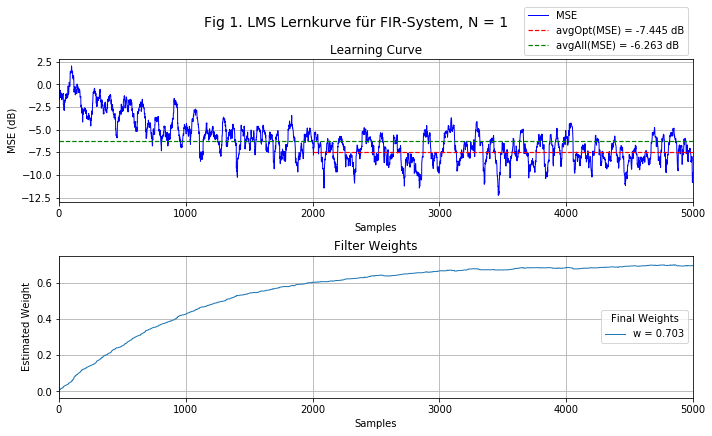

In [4]:
# FIR LMS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 5000

# N = 1
N, mu, var = 1, 0.001, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 1. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='log', avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 1.** 
Um die Komplexität des (unbekannten) FIR-Systems aus der Aufgabe mit $N = 5$ zu erreichen sind, wie im ersten Plot oben zu sehen $N = 1$ Taps nicht hinreichend. Obwohl hier eine nahezu optimale Übertragungsstrecke mit kaum Rauschen vorliegt ($\sigma_1^2 = 0.001$) und die Schrittweite relativ gering gewählt wurde wird das Rauschen bei einem SNR $\approx 27.8 \,dB$ im Verhältnis zum Anfangsfehler durschnittlich um etwa $-7 \,dB$ reduziert.
Die Schrittweite $\mu = 0.001$ wurde absichtlich sehr niedrig gewählt um zu sehen welches Optimum sich einstellt, ohne die Geschwindigkeit der Adaption hier sonderlich zu gewichten.

Dieses Ergebnis war im Abgleich mit meiner Erwartung zu $N = 1$ überraschend gut, da die Rauschreduktion für nur einen Filterkoeffizienten besser ausfiel als zunächst angenommen.

* LMS: N = 2, mu = 0.01, w = [0.70355348 0.06711521]
       with AWGNS variance = 0.01, SNR = 17.98 dB


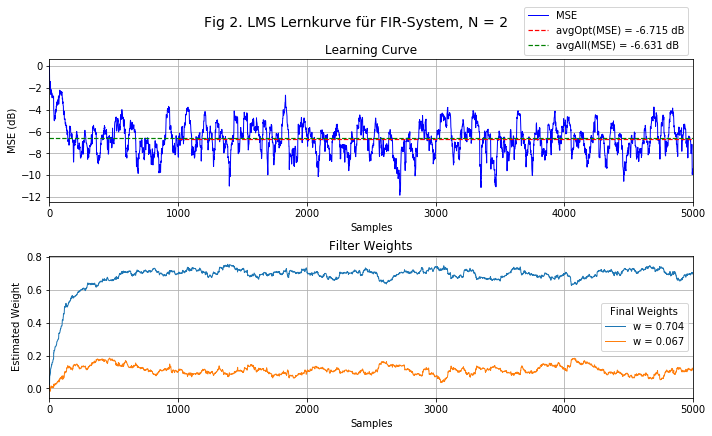

In [5]:
# N = 2

N, mu, var = 2, 0.01, 0.01
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 2. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='log', avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 2.** 
Eine annähernd gute Rauschunterdrückung zu Fig 1 mit $N = 1$ mit etwa $-6.5 \,dB$ im Verhältnis zum ersten Fehlerwert erfolgt trotz der zehnfachen Varianz ($\sigma_2^2 = 0.01 = 10 \cdot \sigma_1^2$) des beigemischten Rauschens bei Verdopplung der Anzahl der Filtertaps auf $N = 2$.

Durch die erhöhte Schrittweite mit $\mu = 0.01$ ist außerdem eine deutlich schnellere Adaption der beiden Filterkoeffizienten zu verzeichnen. Hierdurch wird der durchschnittliche MSE über alle Iterationen auch geringer.

* LMS: N = 5, mu = 0.01, w = [ 0.68030064  0.11149775 -0.02590734  0.18146291 -0.24162041]
       with AWGNS variance = 0.1, SNR = 7.85 dB
* LMS: N = 5, mu = 0.1, w = [ 0.7   0.1  -0.03  0.18 -0.24]
       with AWGNS variance = 0, SNR = 3074.36 dB


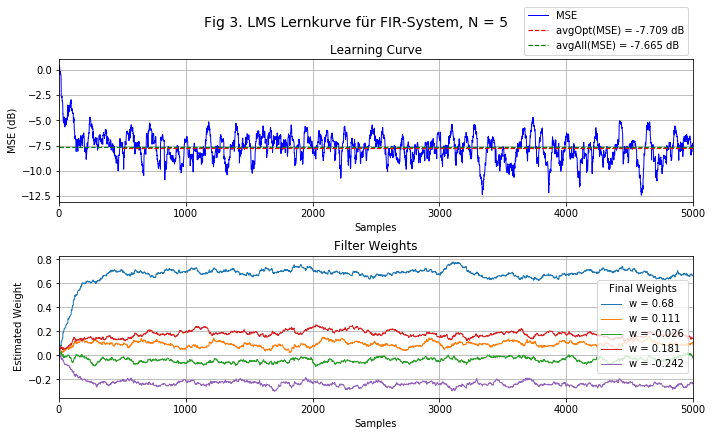

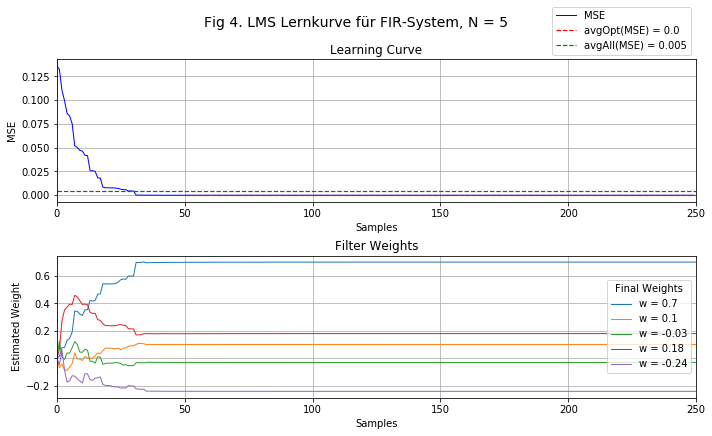

In [6]:
# N = 5

N, mu, var = 5, 0.01, 0.1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 3. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='log', avgFrom=500)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, mu, var = 5, 0.1, 0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, 250, 'Fig 4. LMS Lernkurve für FIR-System, N = '\
             +str(N), style='lin', avgFrom=50)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 3.** Mit $N = 5$ erhält man die selbe Rauschunterdrückung von etwa $-7\,dB$ selbst bei einer weiteren Verzehnfachung der Rauschvarianz im Vergleich zu den Ausgangsbedingungen in *Fig 1* und *Fig 2*.

Erhöht man die Varianz des Rauschens auf $\sigma^2 = 10$ so stellt sich trotz $N = 5$ und einer geringen Schrittweite von $\mu = 0.001$ keine sonderliche Fehlerminimierung jenseits von $-2\,dB$ (ne nach Durchlauf) ein. Die Schwierigkeit der Adaption lässt sich auch in der Darstellung der Filter Weights im unteren Subplot gut sehen: Die Werte der einzelen Filterkoeffizienten pendeln sich nie vollständig ein und schwanken um ein mögliches Optimum.

**Fig 4.** Exemplarisch wird hier eine sehr große Schrittweite von $\mu = 0.1$ *ohne* AWGNS gewählt um zu demonstrieren, dass der LMS Algorithmus unter Optimalbedingungen (kein Rauschen in der Übertragungsstrecke) sehr schnell die exakten, optimale Gewichtung mit $h_0 = 0.7, h_1 = 0.1, h_2 = -0.03, h_3 = 0.18, h_4 = -0.24$ adaptieren kann. Dies entspricht exakt den Werten des eigentlich unbekannten Systems (siehe oben in der Aufgabenstellung). 

Zu beachten: Der Plot (Fig 4.) zeigt durch das dritte Argument hier nur die ersten 250 Iterationen um den Adaptionsverlauf genauer betrachten zu können.

## Aufgabe 1: FIR Systemidentifikation via RLS Algorithmus

* RLS: N = 1, w = [0.70081869]
       with AWGNS variance = 0.001, SNR = 27.93 dB


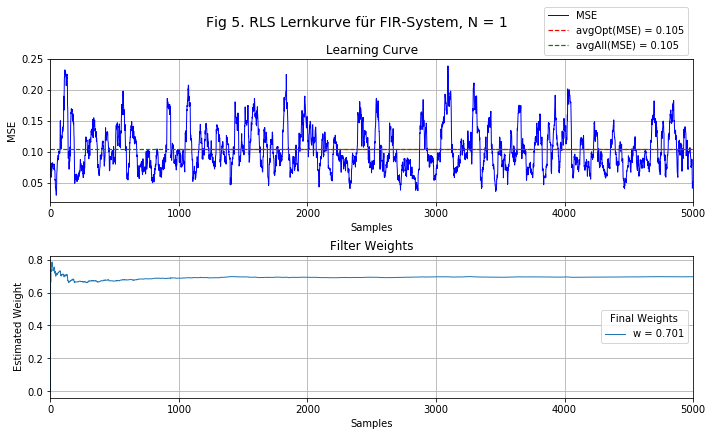

In [7]:
# FIR RLS study
# N  = 1, 2, 5
# var = 0.001, 0.1, 1, 10

# Style of displayed plot
plotLen = 5000

# N = 1
N, var, forget = 1, 0.001, 0.0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 5. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='lin',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 6.** Analog zur Betrachtung des LMS Algorithmus wurde hier zunächst für $N = 1$ das AWGNS möglichst gering gehalten. Eine Verbesserung durch die Adaption des RLS ist schwer festzustellen, denn der Fehler bleibt auch über die gesamte Signallänge etwa gleich groß auch wenn sich die Adaption des Filterkoeffizienten zu $h_0 \approx 0.7$ vergleichsweise schnell einstellt und somit bis auf minimale Abweichungen auf den selben Wert konvergiert wie der LMS Algorithmus.

* RLS: N = 2, w = [0.69929579 0.10520565]
       with AWGNS variance = 0.001, SNR = 27.83 dB


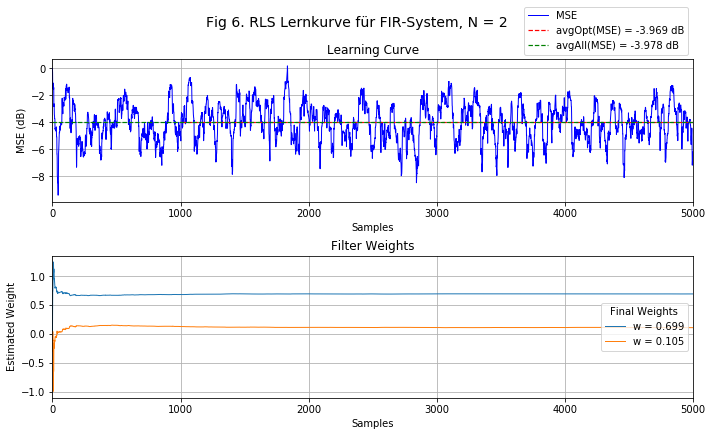

In [8]:
# Style of displayed plot
plotLen = 5000

# N = 2
N, var, forget = 2, 0.001, 0.0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 6. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 7.** Mit der Erhöhung der Anzahl der Filterkoeffizienten auf $N = 2$ und gleichbleibender Varianz des AWGNS stellt sich eine durchschnittliche Fehlerminimierung von etwa $-4\,dB$ ein. Im Vergleich hierzu erzielte der LMS eine bessere Fehlerminimierung, hingegen konvergieren die Filterkoeffizienten deutlich schneller.

* RLS: N = 5, w = [ 0.70000001  0.10000001 -0.03000002  0.18000002 -0.24      ]
       with AWGNS variance = 0.0, SNR = 3074.36 dB
* RLS: N = 5, w = [ 0.69895031  0.09503464 -0.02468956  0.18189815 -0.23823896]
       with AWGNS variance = 0.1, SNR = 7.85 dB


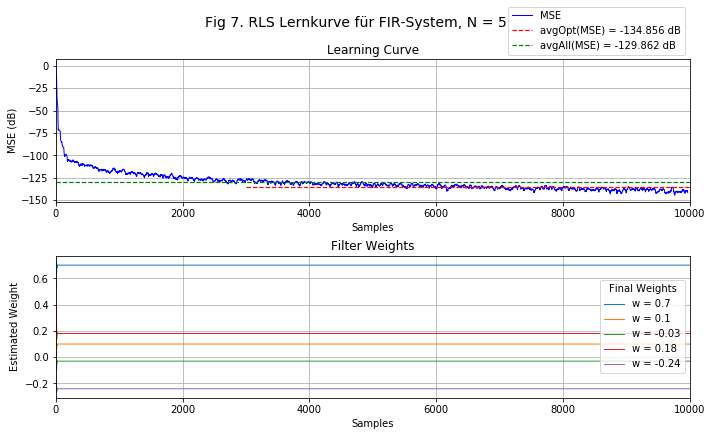

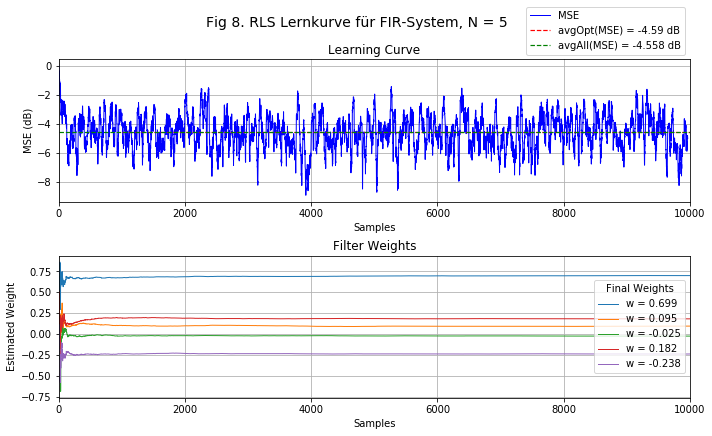

In [9]:
# Style of displayed plot
plotLen = 10000

# N = 5
N, var, forget = 5, 0.0, 0.0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 7. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=3000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, var, forget = 5, 0.1, 0.0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 8. RLS Lernkurve für FIR-System, N = '\
             +str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 7.** Nach Erhöhung der Filterkoeffizienten auf $N = 5$ wurde zunächst untersucht ob sich die bekannte, optimale Lösung mit $h_0 = 0.7, h_1 = 0.1, h_2 = -0.03, h_3 = 0.18, h_4 = -0.24$ ohne Einwirkung des AWGNS einstellt. Im Plot ist die Konvergenz der Filterkoeffizienten auf diese Werte deutlich zu sehen. Zu beachten ist auch die Fehlerreduktion weit nach der Konvergenz der Filterkoeffizienten. Dies begründet sich vermutlich durch das weitere ansammeln von Information (kein einfluss des Vergessensfaktor mit $\rho = 1$) und der damit verbundenen Verbesserung der Filterung.

**Fig 8.** Nach Erhöhung der Rauschvarianz auf $\sigma^2 = 0.1$ ist noch eine durchschnittliche Rauschunterdrückung von etwa $-5\,dB$ zu verzeichnen. Dies ist ein vergleichbares Ergebniss mit dem LMS - doch stellt sich hier die Adaption des LMS deutlich schneller ein.

Selbst nach einer Erhöhung der Rauschvarianz auf $\sigma^2 = 10$ ist noch eine durchschnittliche Fehlerminimierung von etwa $-1\,dB$ bis $-5\,dB$ im Bezug auf den ersten Fehlerwert zu verzeichnen.

#### Zwischenfazit FIR Identifikation
Die Adaption des RLS Algorithmus verläuft deutlich schneller und erzielt vergleichbare Ergebnisse zu dem LMS Algorithmus bei der Rauschunterdrückung bzw. Identifikation des linearen FIR-Systems mit AWGNS gestörter Übertragungsstrecke. Wichtig ist im Allgemeinen bei beiden Algorithmen eine ausreichende Anzahl von Filtertaps $N$ und eine sinnvolle Größe für die Schrittweite $\mu$ des LMS Algorithmus. 

Eine Betrachtung des Vergessensfaktors des RLS Algorithmus musste bisher nicht getätigt werden, da es sich bei dem beigemischten AWGNS um einen stationären stochastischen Prozess handelt und der Vergessensfaktor somit keine Verbesserung verspricht. Diese Vermutung wurde anhand ein paar Probedurchläufe bestätigt.

## Aufgabe 2: IIR Systemidentifikation
Für das IIR-Filter: Stelle die gleichen Untersuchungen wie beim FIR-Filter an.

Bemerkung: Da weder RLS noch LMS im Vergleich zu dem vorliegenden IIR-System einen rekursiven Anteil besitzen, ist zu erwarten das die Adaption mehr als nur $N = 2$ Filterkoeffizienten brauchen wird um das IIR-System hinreichend approximieren zu können.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


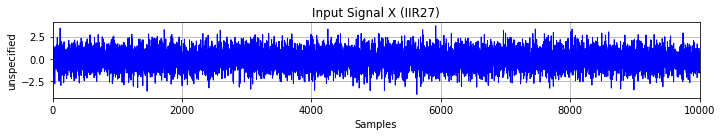

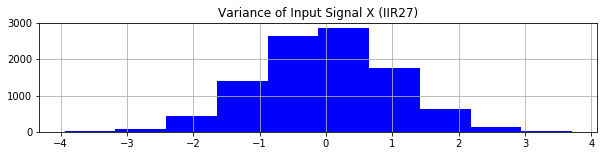

In [10]:
# load IIR data from dictionary
HiirD = importMat['System_IIR27']['D_']
HiirX = importMat['System_IIR27']['X']

# check input signal variance and plot
ts.plot(HiirX,'Input Signal X (IIR27)','lin',10000)
ts.hist(HiirX,'Variance of Input Signal X (IIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))
#print('Eigenvalue Spread of X:', ts.eigSpread(HiirX,1000))

* LMS: N = 1, mu = 0.001, w = [1.02435977]
       with AWGNS variance = 0.001, SNR = 34.51 dB
* RLS: N = 1, w = [1.02510471]
       with AWGNS variance = 0.001, SNR = 34.62 dB


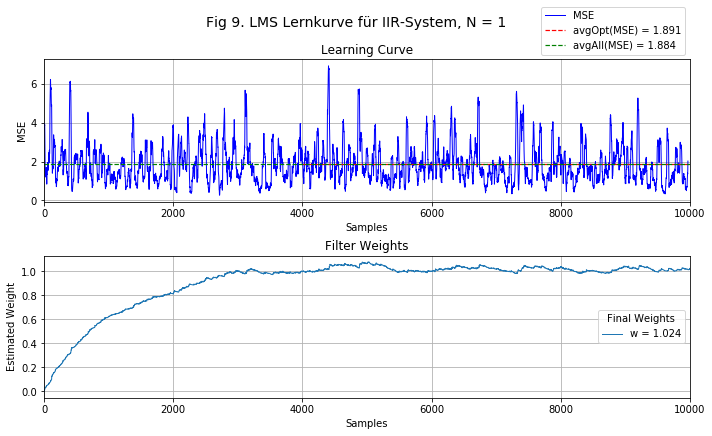

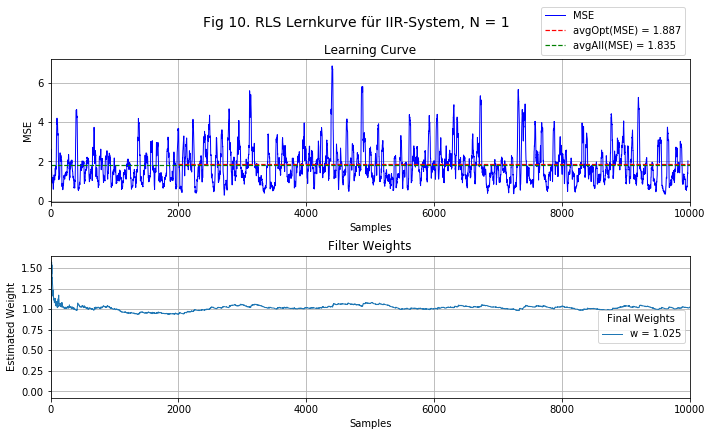

In [11]:
# IIR LMS/RLS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen =10000
plotStyle = 'lin'

# LMS, N = 1
N, mu, var = 1, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 9. LMS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=4000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 1
N, var, forget = 1, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 10. RLS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 9 & 10.** 
Sowohl der LMS-Algorithmus als auch der RLS-Algorithmus erzielen anhand des IIR-Systems bei einer Rauschvarianz von $\sigma^2 = 0.001$ und $N = 1$ eine Fehlerminimierung von etwa $\approx -2\,dB$ bis $-4\,dB$. Der durschnittliche Fehler ist für beie Algorithmen vergleichbar groß

Es ist zu bemerken das hierfür aber eine relativ lange Adaptionszeit (~4000 Samples) für den LMS in Kauf genommen wird. Der RLS-Algorithmus konvergiert hierbei deutlich schneller und erzielt daher auch früher bessere Ergebnisse.
Eine Approximation des IIR-Systems mit $N = 1$ erscheint nicht sonderlich sinnvoll.

* LMS: N = 2, mu = 0.001, w = [0.99885361 0.83983943]
       with AWGNS variance = 0.001, SNR = 34.63 dB
* RLS: N = 2, w = [0.99887993 0.84051451]
       with AWGNS variance = 0.001, SNR = 34.71 dB


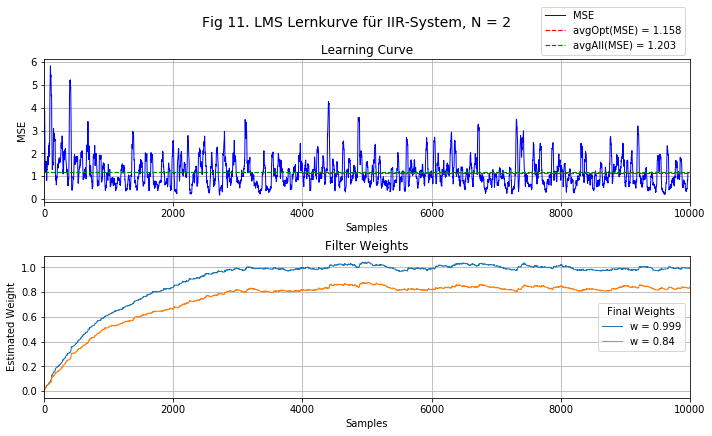

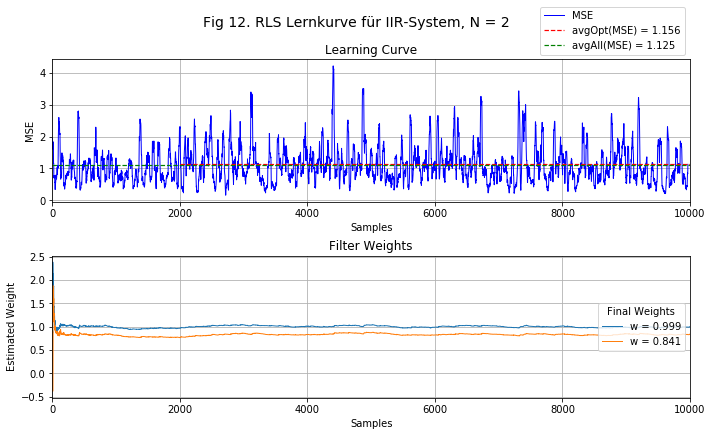

In [12]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 11. LMS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=4000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var, forget = 2, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 12. RLS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 11 & 12.**
Bei Erhöhung der verfügbaren Filterkoeffizienten auf $N = 2$ bei gleichbleibender Rauschvarianz erzielen auch hier beide Algorithmen vergleichbare Ergebnisse mit einem durchschnittlichen Fehler von $1.16$. Da sich der zugrundeliegende Prozess nicht verändert bringt eine Verkleinerung von $\rho < 1$ des RLS keinen ersichtlichen Unterschied und führt bei zu kleinen Werten zu Instabilität und schlechteren Ergebnissen. Dies ist dem bisher sonst gradlinigne Verlauf der Filtergewichte nach der Konvergenz zu entnehmen. Durch $\rho = 1 -$ `memleak` $= 1 - 0.001 = 0.999$ ist schon eine leichte Instabilität des Filters durch das schwanken der Filterkoeffizienten zu beobachten.

Bemerkung: Aufgrund der schlechten Vergleichbarkeit der Angabe des durchschnittlichen MSE in $dB$ hinsichtlich des Bezugswertes $e_0$ wird im folgenden häufiger darauf verzichtet. Die Darstellung im Plot ist durch das Argument `style = 'lin'` bzw. `style = 'log'` modifizierbar.

Für längerfristige Untersuchungen würde sich eine optimierte Implementierung, die den SNR vor und nach der Filterung durch beide Algorithmen anbieten. Dies würde die relevanz der Bezugswerte vermindern.

* LMS: N = 5, mu = 0.01, w = [0.98151893 0.68954802 0.7157751  0.50300243 0.47677797]
       with AWGNS variance = 1, SNR = 4.59 dB
* RLS: N = 5, w = [0.99862453 0.82731258 0.62812487 0.47846891 0.38880519]
       with AWGNS variance = 1, SNR = 4.62 dB


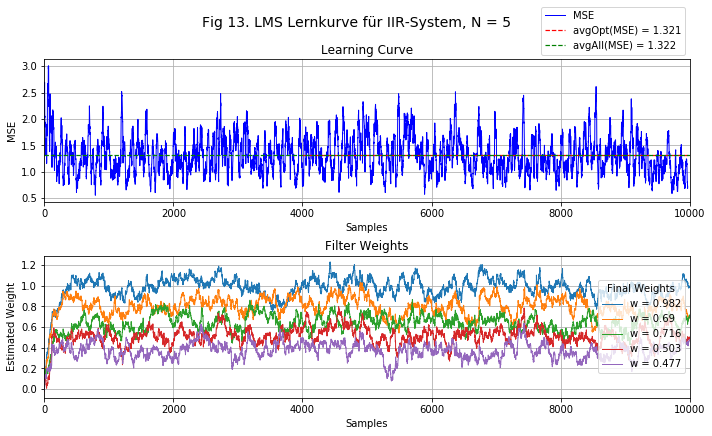

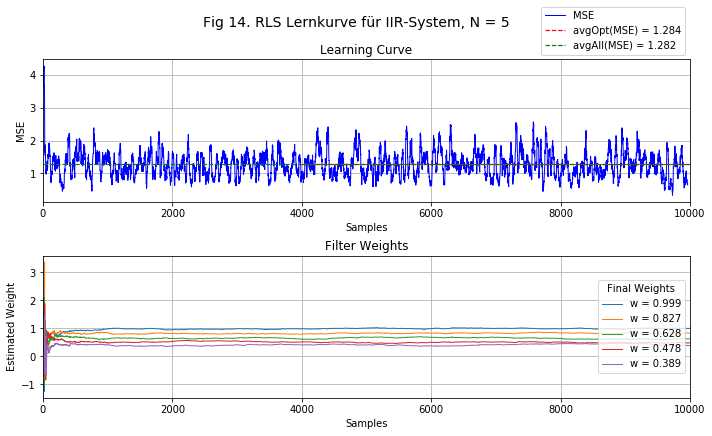

In [13]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'
avgFrom = 4000

# LMS, N = 5
N, mu, var = 5, 0.01, 1
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 13. LMS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=avgFrom)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var, forget = 5, 1, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 14. RLS Lernkurve für IIR-System, N = '\
             +str(N), style=plotStyle,avgFrom=avgFrom)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 13 & 14.** 
Nach Erhöhung der Filterkoeffizienten auf $N = 5$ und der Rauschvarianz des AWGNS auf $\sigma^2 = 1$ erzielen sowohl der RLS als auch der LMS Algorithmus mit einem durchschnittlchen MSE $\approx 1.3$ sehr ähnliche Ergebnisse.

Auch wenn das Adaptionsverhalten des LMS durch die Erhöhung der Schrittweite auf $\mu = 0.01$ chaotischer wirkt lassen sich so im Schnitt bessere Ergebnisse erzielen als durch eine geringere Schrittweite von $\mu = 0.001$. Diese Beobachtung war für mich überraschend, da ich zunächst erwartet hatte das beste Ergebnis mit der kleinsten, sinnvollen Schrittweite zu erzielen. Hier zeigt sich jedoch das die Adaption des LMS nicht optimal konvergieren muss, sondern auch sehr dynamisch verlaufen kann.

#### Zu Aufgabe 1 & 2: Systemidentifikation eines FIR/IIR-Systems mit variablem AWGNS via LMS und RLS Algorithmus

Im Allgemeine unterscheiden sich der LMS- und der RLS-Algorithmus anhand ihrer Konvergenzzeit, der resultierenden Fehlerminimierung, dem Rechenaufwand und eignen sich daher jeweils für spezifische Anwendungsfälle.

Ein Hauptmerkmal des LMS Algorithmus liegt darin, dass es sich um einen Markov Prozess handelt. Der LMS besitzt einen Momentanzustand, speichert aber keine vergangenen Daten im laufenden Vorgang des Adaptionsprozesses. Diese Eigenschaft ist auch gut für zeitlich veränderliche Systemeigenschaften geeignet, denn vergangene Information würde sonst zu fehlerhafter Information über die momentanen Werte führen. Diese Eigenschaft wird sich sicher in der folgenden Simulation des Systemwechsels (Aufgabe 3) besonders zeigen. Im Austausch für dieses Verhalten pendeln sich die Werte des Filters trotz zu beobachtender Konvergenz nie ganz ein, sondern kreisen immer um ein Optimum. In dieser Hinsicht ist der RLS "stabiler" in der Konvergenz der Filterkoeffizienten (Bemerkung: Mit "Stabilität" ist hier nicht das Verhalten des Filters gemeint, denn ein FIR-Filter ist immer stabil da er keinen rekursiven Anteil besitzt). Dieser Eigenschaft des LMS kann durch einer variablen bzw. adaptiven Schrittweite $\mu$ beholfen werden. So könnte sich die Schrittweite reduzieren, falls der Fehler über mehrere Iterationen kleiner wird. Analog hierzu könnte die Schrittweite vergrößert werden, falls der Fehler sicher über mehrere Interationen wieder vergrößert.

Der RLS-Algorithmus hingegen verwendet außer den Momentanwerten auch alle vergangenen Informationen zur Optimierung der Adaption. Dies kann im Gegensatz zur Funktionalität des LMS zu fehlerhaftem Verhalten bei zeitlich veränderlichen Prozessen führen. Diese Schwachstelle kann vermindert werden indem ein sogenannter Vergessensfaktor im RLS Algorithmus eingeführt wird, welcher vergangene Werte bis hin zum _"absoluten Vergessen"_ weniger stark gewichtet. Diese Funktionalität war für die bisherigen Untersuchungen nicht notwendig, da sich laut der Vorgabe die Größen der zugrundeliegenden stationären stochastischen Prozesse nicht ändern. Auch experimentelle Ergebnisse unterstreichen diese These, denn eine Justierung des Vergessensfaktors $\rho$ brachte keine merkliche Verbesserung im Adaptionsverhalten.

Betrachtet man die benötigten Resourcen ist der RLS Algorithmus rechenintensiver gegenüber dem LMS Algorithmus. Im Austausch hierzu konvergiert der RLS Algorithmus deutlich schneller und bleibt bei einmaliger Konvergenz sehr stabil. Bei stochastisch stationären Prozessen liefert der RLS-Algorithmus also stabile Ergebnisse und ist bei außreichend verfügbarer Rechenleistung zu bevorzugen. Dies zeigt sich auch in der Verbesserung des Signal-Rausch-Verhältnis, denn der RLS führt im Schnitt bei der selben Rauschvarianz zu besseren Ergebnissen durch eine bessere Rauschunterdrückung bzw. geringerer Rauschanfälligkeit bei der Systemidentifikation. 

Durch die beschleunigte Adaption des RLS Algorithmus ist außerdem der resultierende Gesamtfehler kleiner, was in einem Anwendungsfall schneller zu einem optimalen Ergebnissen führen würde. Dies ist u.a. an den durchschnittlichen Fehlerwerten `avgOpt(E)` und `avgAll(E)` zu sehen. Im folgenden (ab Aufgabe 3) eignet sich die Bildung dieser beiden Fehlerwerte auch um den durchschnittlichen Fehler vor- und nach dem Systemwechsel, sowie über den gesamten Verlauf zu ermitteln. Die qualitative Bezeichnung "Opt" und "All" sind hier aber nicht mehr zutreffend. Die Strecke über welche der Mittelwert der Legende gebildet wird ist wie bisher auch der Linien im Plot zu entnehmen.

<!---
Im Allgemeinen ist es bekannt das der RLS-Algorithmus besser für deterministische Prozesse geeignet ist und der LMS-Algorithmus für stochastische Prozesse. Da in dieser Simulation primär die Adaption für stochastische Prozesse (AWGNS) analysiert wird ist auch nicht zu erwarten, dass der RLS-Algorithmus im Vergleich zum LMS besser abschneidet.
-->


<!---
RLS vs LMS Performance: https://dsp.stackexchange.com/a/8188/32224
RLS, LMS and Wiender: https://dsp.stackexchange.com/a/50366/32224
-->


## Aufgabe 3: Systemwechsel
Es soll nun der Einfluss eines plötzlichen Systemwechsels untersucht werden. Dazu werden die Filterkoeffizienten des erzeugenden Systems nach 5000 Iterationen geändert. Lade nun die Datei Systemwechsel_FIR.mat und Systemwechsel_IIR.mat. Sie enthalten die gleichen Signale wie schon System_FIR.mat und System_IIR.mat. Zeige wiederum das Lernverhalten für verschiedene Störeinflüsse, Lernalgorithmen und Fitlerordungen. Erläutere auch hieran das Adaptionsverhalten. 

Welches Verfahren eignet sich unter welchen Bedingungen am besten?

Input signal 1 mean:  -0.010424975412711203
Input signal 1 variance:  0.5975436877185286
Input signal 2 mean:  -0.035691786431926054
Input signal 2 variance:  1.2498135548043237


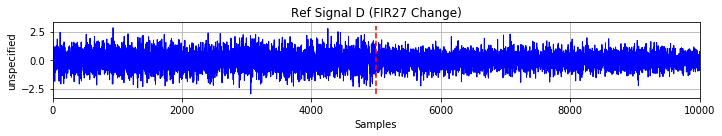

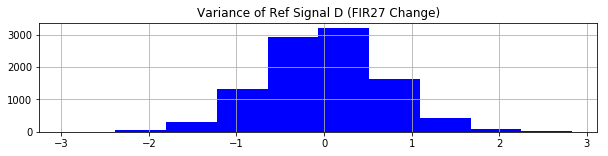

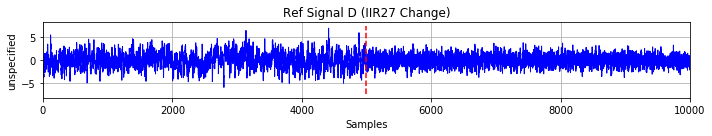

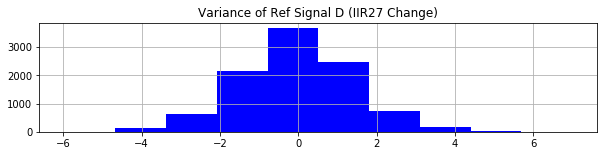

In [14]:
# load FIR data from dictionary
HfirDc = importMat['Systemwechsel_FIR27']['D_']
HfirXc = importMat['Systemwechsel_FIR27']['X']
HiirDc = importMat['Systemwechsel_IIR27']['D_']
HiirXc = importMat['Systemwechsel_IIR27']['X']

# check input signal 1 variance and plot
ts.plot(HfirDc,'Ref Signal D (FIR27 Change)','lin',10000)
plt.plot([5000, 5000],[-3, 3], 'r--')
ts.hist(HfirDc,'Variance of Ref Signal D (FIR27 Change)')
print('Input signal 1 mean: ',np.mean(HfirDc[0,0:5000]))
print('Input signal 1 variance: ',np.var(HfirDc[0,0:5000]))

# check input signal 2
ts.plot(HiirDc,'Ref Signal D (IIR27 Change)','lin',10000)
plt.plot([5000, 5000],[-7.5, 7.5], 'r--')
ts.hist(HiirDc,'Variance of Ref Signal D (IIR27 Change)')
print('Input signal 2 mean: ',np.mean(HiirDc[0,5000:]))
print('Input signal 2 variance: ',np.var(HiirDc[0,5000:]))

**Plots oben:** Klar in den Plots oben zu sehen ist der Systemwechsel bei der Hälfte (ab Sample 5000) des Signals.

* LMS: N = 5, mu = 0.01, w = [ 1.02360103  0.39049727  0.13142293  0.08660753 -0.00442538]
       with AWGNS variance = 0.1, SNR = 13.28 dB
* RLS: N = 5, w = [ 1.06525107  0.39794207  0.09470852  0.03953599 -0.02494751]
       with AWGNS variance = 0.1, SNR = 13.26 dB


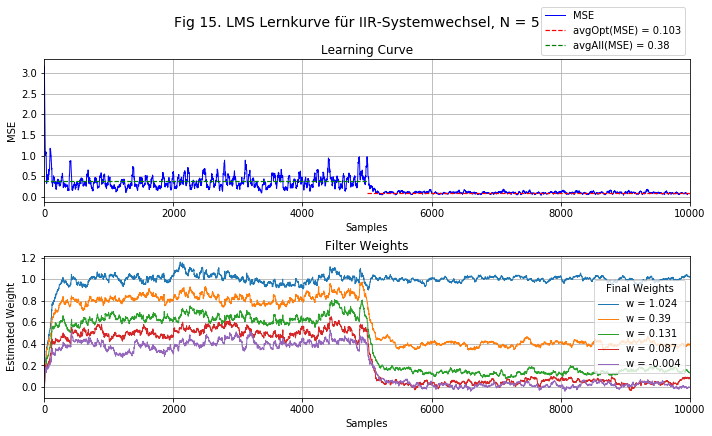

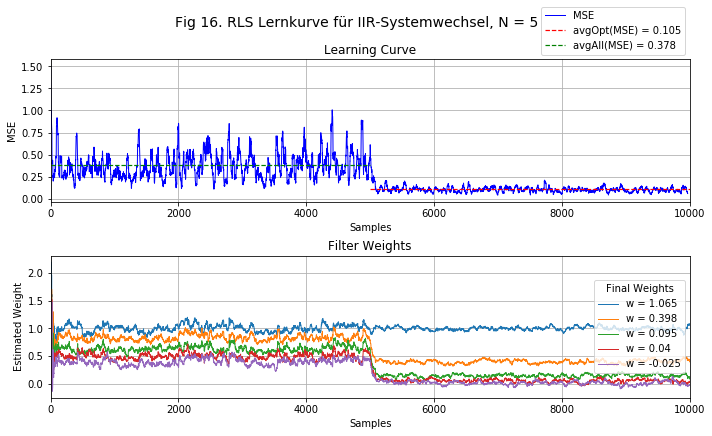

In [15]:
# IIR LMS/RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 5
N, mu, var = 5, 0.01, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 15. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var, forget = 5, 0.1, 0.02
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 16. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

Bemerkung: Es wird zunächst der Systemwechsel des IIR-Systems untersucht.

**Fig 17 & 18.** 
Im Vergleich des RLS- und LMS-Algorithmus im Plot oben ist sowohl die laufende Adaption des LMS als auch die Auswirkung des Vergessensfaktors gut zu erkennen, denn die Filterkoeffizienten konvergieren nach dem Systemwechsel relativ schnell auf ein neues Optimum. Sowohl die sich einstellenden Filterkoeffizienten als auch der Restfehler ähneln sich unter den obigen Einstellungen sehr.

Um also ähnlich gute Ergebnisse zum LMS durch den RLS Algorithmus erzielen zu können muss das Argument `memleak` mit $\rho = 1 -$ `memleak` und $0 < \rho < 1$ passend justiert werden. Analog hierzu muss natürlich auch die Learning Rate $\mu$ des LMS angepasst werden. 

Es gilt dabei immer einen Kompromiss zwischen der Stabilität der Filterkoeffizienten und dem resultierenden Reaktionsvermögen der Adaption zu finden. Eine zu große Schrittweite $\mu$ bzw. ein zu klein gewählter Vergessensfaktor $\rho$ führen zu "nervöserem" Verhalten (jitter) der Algorithmen. Reziprok hierzu zeigt sich zwar ein glatterer Adaptionsverlauf jedoch eine sehr träge Adaption der Filter bei Änderung der Systemeigenschaften.

* LMS: N = 2, mu = 0.01, w = [0.99684658 0.40435653]
       with AWGNS variance = 0.001, SNR = 33.24 dB
* RLS: N = 2, w = [1.0093568  0.43568234]
       with AWGNS variance = 0.001, SNR = 33.18 dB


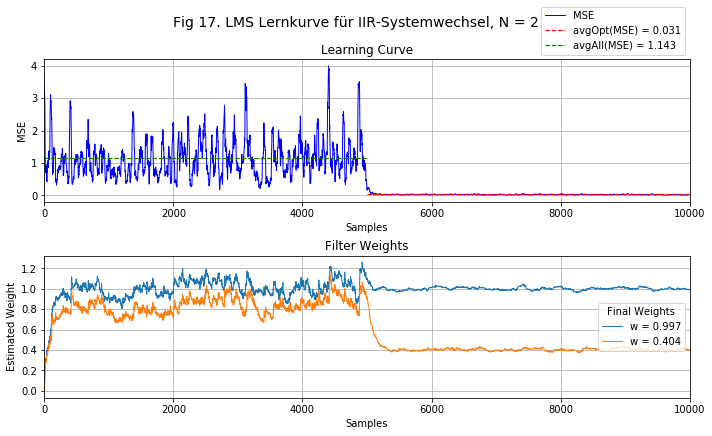

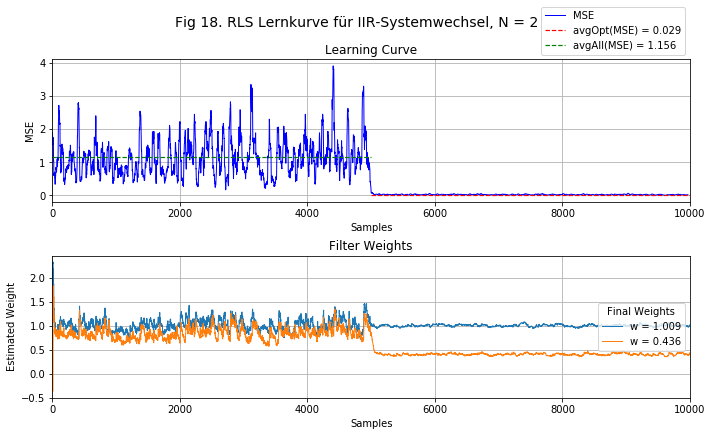

In [16]:
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.01, 0.001
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 17. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var, forget = 2, 0.001, 0.03
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 18. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 17 & 18.**
Ähnlich zur Verwendung von $N = 5$ Filterkoeffizienten sind bei $N = 2$ und passender Justierung von $\mu$ und $\rho$ ähnliche Ergebnisse zwischen dem LMS- und RLS Algorithmus zu erzielen.

* LMS: N = 5, mu = 0.01, w = [ 0.40621727 -0.02149541  0.28749128 -0.17389114 -0.21167216]
       with AWGNS variance = 0.01, SNR = 16.75 dB
* RLS: N = 5, w = [ 0.38129982 -0.01771791  0.32751842 -0.17264521 -0.19139918]
       with AWGNS variance = 0.01, SNR = 16.78 dB


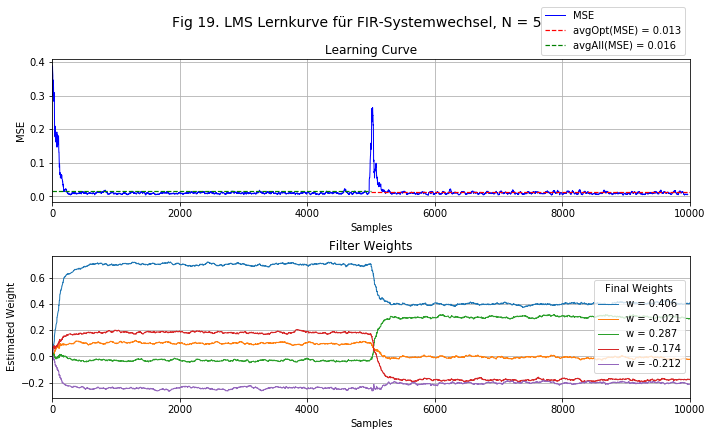

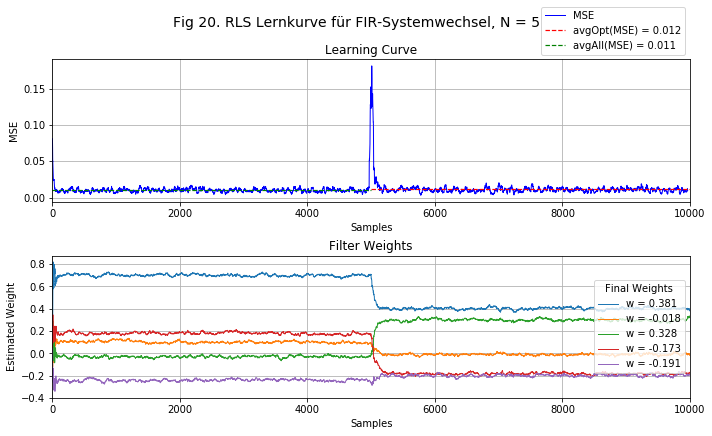

In [17]:
# FIR LMS/RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10
plotStyle = 'lin'

# LMS, N = 5
N, mu, var = 5, 0.01, 0.01
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 19. LMS Lernkurve für FIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var, forget = 5, 0.01, 0.02
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 20. RLS Lernkurve für FIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 19 & 20.**
Ähnlich zu den Experimenten des IIR-Systemwechsels zeigt sich eine rasche Adaption der Filterkoeffizienten der LMS und RLS Algorithmen mit dem Resultat eines nur kurzzeitig ansteigenden MSE zum Zeitpunkt des Wechsels.

Durch Modifikation der Lernrate (LMS) und dem Vergessensfaktor (RLS) gilt es im Allgemeinen den Restfehler gegen die Geschwindigkeit der Adaption abzuwägen.

* LMS: N = 2, mu = 0.01, w = [0.39097132 0.04430803]
       with AWGNS variance = 0.1, SNR = 6.68 dB
* RLS: N = 2, w = [0.31616682 0.0293689 ]
       with AWGNS variance = 0.1, SNR = 6.71 dB


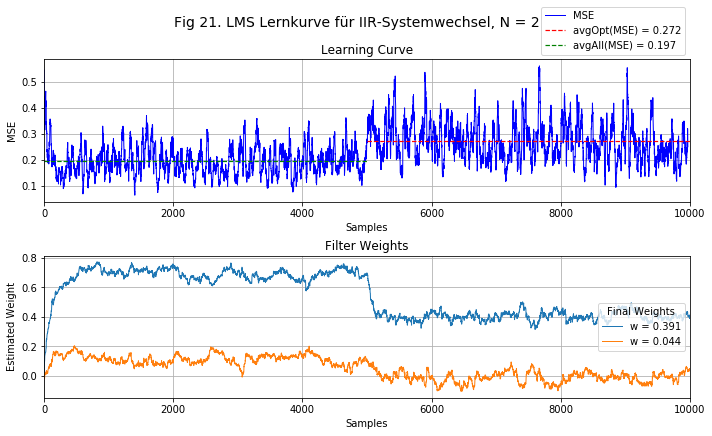

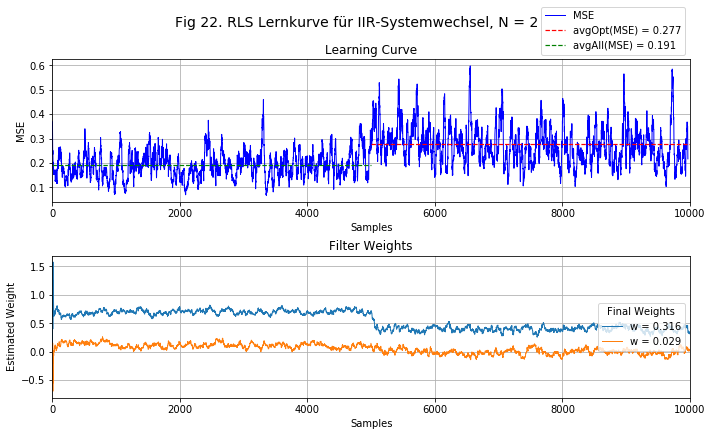

In [18]:
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.01, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 21. LMS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var, forget = 2, 0.1, 0.02
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N), memleak=forget)
ts.errorPlot(E, W, plotLen, 'Fig 22. RLS Lernkurve für IIR-Systemwechsel, N = '\
             +str(N), style=plotStyle, avgFrom=5000, avgTo=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 21 & 22.**
Auch nach Reduzierung der verfügbaren Filtertaps auf $N = 2$ lässt sich das obige Verhalten beobachten. Signifikant ist jedoch, das sich der Anstieg und weitere Verlauf des MSE (Lernkurve) nach dem Systemwechsel etwa gleich gravierend auf den LMS uns RLS auswirkt. Die Anzahl der Filtertaps mit $N = 2$ ist im Allgemeinen zu gering für das Problem gewählt.

#### Zu Aufgabe  3: Systemwechsel

Der LMS Algorithmus zeigt aufgrund seiner Adaptionsfreudigkeit und momentarischen Betrachtung des Zeitverlaufs eine gute Eigenung bei einem auftretenden Systemwechsel oder bei Änderung der Randbedingungen im Allgemeinen. Diese Robustheit gegenüber zeitlichen Änderungen des Systems und der Übertragungsstrecke bezeugen die Eignung für alle Fälle, die ein solches Verhalten erwarten lassen.

Der RLS Algorithmus zeigt zunächst ein schnelleres Adaptionsverhalt als der LMS. Durch den Systemwechsel ist die angesammelte Information für den RLS aber keine Hilfe mehr sondern wird zum Hindernis in der Adaption indem vergangene, redundante Information im Verhältnis zum aktuellen Zustand des Systems zu stark gewichtet werden. Dieses Verhalten macht den RLS Algorithmus anfällig für zeitliche Veränderungen des Systems und für allgemeine Veränderungen der Randbedingungen. Diese Eigenschaft des RLS wurde bereits in Aufgabe 2 (etwas frühzeitig) beschrieben.

Durch die Anpassung des Vergessensfaktors, ähnlich zur Justierung der Schrittweite, lassen sich auch für den RLS gute oder sogar bessere Ergebnisse erzielen. Wählt man den Vegessesnfaktor richtig, so stellt sich trotz Systemwechsel ein schneller Adaptionsverhalten ein. Lässt man den RLS jedoch zu schnell vergessen erhöht sich der durchschnittliche Restfehler (MSE). Es gilt also diese beiden Verhalten abzuwägen. Geeignet für einen solche Optimierungsprozess der Hyperparameter $\mu$ und $\rho$ wäre eine nested cross validation mit einem geeignetem Datensatz.

## Aufgabe 4: Kernel Least Mean Squares (KLMS)
Es soll nun ein Kernel Least Mean Squares (KLMS) Filter entworfen werden, dass eine Zeitreihenschätzung vornimmt. Zum Training wird eine Zeitreihe mit 500 Werten in der Datei Training.mat gegeben. Das trainierte Filter soll anschließend mit der Zeitreihe in Test.mat getestet werden. Der Kernel des KLMS darf aus der Familie der Exponentialfunktionen frei gewählt werden (Gauss, Laplace, o.ä.). Zum Vergleich der Schätzfähigkeit des KLMS sollen sowohl 5 vergangene als auch 10 vergangene Werte zur Schätzung herangezogen werden. Das gleiche Testszenario soll weiterhin mit einem LMS umgesetzt und für einen Vergleich zum KLMs herangezogen werden. Dazu sind Fehlerkurven auf den Testdaten zu erstellen sowie Erläuterungen zu den Einflüssen der jeweiligen Parameter der Filter anzugeben.

*** Importing files from directory: ./data/
* importing: System_FIR27.mat
* importing: System_IIR27.mat
* importing: Systemwechsel_FIR27.mat
* importing: Systemwechsel_IIR27.mat
* importing: Test.mat
* importing: Training.mat
*** 6 files imported
Traning mean:  0.8981513369893664
Training variance:  0.06541574384976366


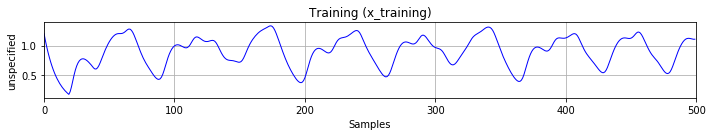

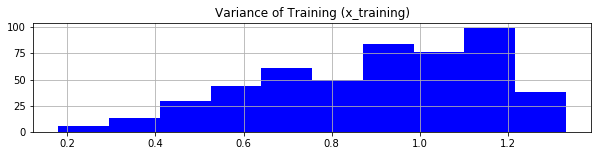

In [19]:
# imports
import algorithms as algo
import tools as ts
import kernels as ks
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sb

# load KLMS training and test data from dictionary
importMat, fileNames = ts.importmat('./data/')
x_training = importMat['Training']['x_training'].T
x_test = importMat['Test']['x_test'].T

# check Training
ts.plot(x_training,'Training (x_training)','lin',500)
ts.hist(x_training,'Variance of Training (x_training)')
print('Traning mean: ',np.mean(x_training))
print('Training variance: ',np.var(x_training))

In [20]:
# KLMS
import algorithms as algo
import tools as ts

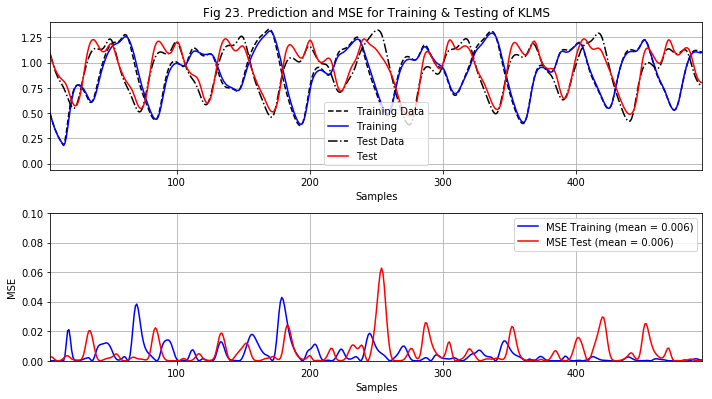

In [21]:
N = 5
var = 0.001

# KLMS Test Tool
# test / train data segment
start = 0
length = 500
end = start + length

traindata = x_training[:,start:end]
testdata = x_test[:,start:end]

# # # # # PLOT # # # # # #
plt.clf()
fig = plt.figure(figsize=(10, 6))

# Data vs Prediction
plt.subplot(211)

# Training
Kern = algo.klms(N, 'gauss', mu=0.6, sigma=1.0) # sig = 0.5 for N = 5
algo.Klearn(Kern, N, traindata)
E = Kern.errors # save error of training
plt.plot(traindata.T[N-1:],'k--',label='Training Data')
plt.plot(Kern.prediction,'b',label='Training')

# Testing
algo.Kpredict(Kern, N, testdata)
plt.plot(testdata.T[N:],'k-.',label='Test Data')
plt.plot(Kern.prediction,'r',label='Test')
plt.xlim([N,length-N])
plt.xlabel('Samples')
plt.grid(True)
plt.legend()
plt.title('Fig 23. Prediction and MSE for Training & Testing of KLMS')

# MSE
trainMean = np.around(np.mean(E), decimals=3)
testMean = np.around(np.mean(Kern.errors), decimals=3)

plt.subplot(212)
plt.plot(E,'b',label='MSE Training (mean = '+str(trainMean)+')')
plt.plot(Kern.errors,'r',label='MSE Test (mean = '+str(testMean)+')')
plt.ylim([0, 0.1])
plt.xlim([N,length-N])
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

**Fig 23.** Im obigen Plot sind sowohl Training- als auch der Testdurchlauf für den KLMS mit $N = 5$ Taps. Mit der Schrittweite $\mu = 0.5$ und einer Breite der Gauss-Kerne mit $\sigma = 1.0$ wurden hier die besten Ergebnisse erzielt.

Man bemerke die erfolgreiche Adaption des Algorithmus im Trainingsdurchlauf mit kleinerem Fehler als im Trainingsdurchlauf. Ein solches Verhalten ist bei der Analyse eines Lernprozesses zu erwarten.

In [22]:
# Vergleich LMS und KLMS

# test / train data segment
start = 0
length = 5000
end = start + length

traindata = x_training
testdata = x_test[:,start:end]

In [23]:
# KLMS Training, N = 5
N = 5
Kern = algo.klms(N, 'gauss', mu=0.5, sigma=1.0) # sig = 0.5 for N = 5
algo.Klearn(Kern, N, traindata)

# LMS Training, N = 5
mu, var = 0.01, 0.0
Elms, Wlms, w, Yd = algo.lmsAlg(N, mu, testdata, testdata, np.zeros(N), \
                                predict=True) # ! prediction

# KLMS Prediction
algo.Kpredict(Kern, N, testdata)

# LMS Prediction
X = testdata

# use final pre-trained Weights
w = Wlms[:,-1:]

Xlen = X.shape[1]
y = np.zeros(Xlen)
E = np.zeros(Xlen)
for i in range(N,Xlen):
    # Input vector
    x = X[:,i-N:i][0][::-1]
    
    # Prediction value
    y[i] = np.dot(x,w)
    
    # Save error
    Elms[i] = (y[i] - X[:,i])**2
    

* LMS: N = 5, mu = 0.01, w = [0.34955335 0.27051849 0.19166866 0.11710781 0.05051431]


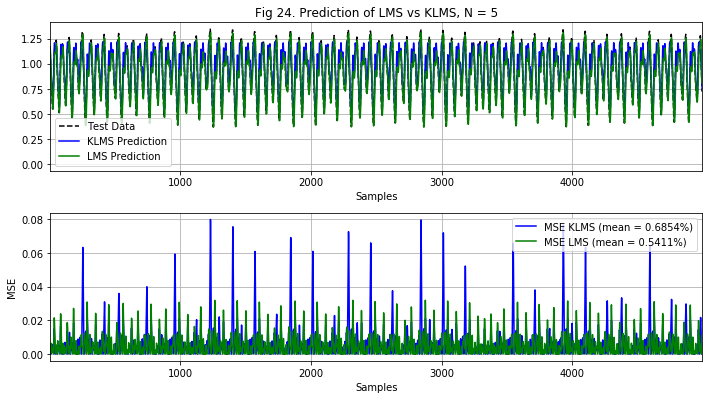

In [24]:
plotLen = 5000

# Prepare Data
klmsPre = Kern.prediction
lmsPre = y

# # # # # PLOT # # # # # #
plt.clf()
fig = plt.figure(figsize=(10, 6))

# Data vs Prediction
plt.subplot(211)

# Test Prediction KLMS vs LMS
plt.plot(testdata.T[N:plotLen],'k--',label='Test Data')
plt.plot(Kern.prediction[0:plotLen],'b',label='KLMS Prediction')
plt.plot(y[N:plotLen],'g',label='LMS Prediction')
plt.xlim([N,plotLen-N])
plt.xlabel('Samples')
plt.grid(True)
plt.legend()
plt.title('Fig 24. Prediction of LMS vs KLMS, N = '+str(N))

# MSE
klmsMean = np.around(np.mean(Kern.errors)*100, decimals=4)
lmsMean = np.around(np.mean(Elms)*100, decimals=4)

plt.subplot(212)
plt.plot(Kern.errors[0:plotLen],'b',\
         label='MSE KLMS (mean = '+str(klmsMean)+'%)')
plt.plot(Elms[0:plotLen],'g',label='MSE LMS (mean = '+str(lmsMean)+'%)')
plt.xlim([N,plotLen-N])
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

**Fig 24.** Die ersten 1000 Werte der Zeitreihenschätzung und der MSE für jede Prädiktion für LMS und KLMS im Vergleich für $N = 5$.

Bemerkung: Der durchschnittliche MSE über alle Iterationen ist in Prozent mit $0.01 \cdot 100 = 1.0\,\%$ angeben. Diese Entscheidung ist aus darstellungstechnischen Gründen gefällt worden.

In [25]:
# KLMS Training, N = 10
N = 20
Kern = algo.klms(N, 'gauss', mu=0.09, sigma=1.0) # sig = 0.5 for N = 5
algo.Klearn(Kern, N, traindata)

# LMS Training, N = 5
mu, var = 0.01, 0.0
Elms, Wlms, w, Yd = algo.lmsAlg(N, mu, testdata, testdata, np.zeros(N), \
                                predict=True) # ! prediction

# KLMS Prediction
algo.Kpredict(Kern, N, testdata)

# LMS Prediction
X = testdata

# use final pre-trained Weights
w = Wlms[:,-1:]

Xlen = X.shape[1]
y = np.zeros(Xlen)
E = np.zeros(Xlen)
for i in range(N,Xlen):
    # Input vector
    x = X[:,i-N:i][0]
    x = x[::-1]
    
    # Prediction value
    y[i] = np.dot(x,w)
    # Save error
    Elms[i] = (y[i] - X[:,i])**2

* LMS: N = 20, mu = 0.01, w = [ 0.33947111  0.26918193  0.20143431  0.1396713   0.0865722   0.0436894
  0.01133174 -0.01130026 -0.02578759 -0.03406842 -0.03801202 -0.03906717
 -0.03803261 -0.03496754 -0.02923543 -0.01965838 -0.00475665  0.01695461
  0.04665722  0.08497245]


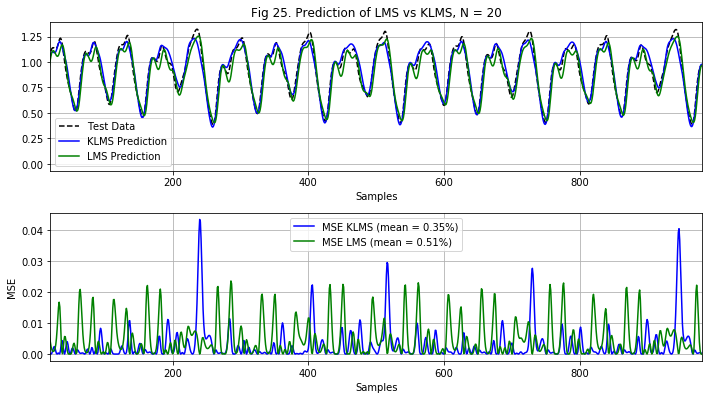

In [26]:
plotLen = 1000

# Prepare Data
klmsPre = Kern.prediction
lmsPre = y

# # # # # PLOT # # # # # #
plt.clf()
fig = plt.figure(figsize=(10, 6))

# Data vs Prediction
plt.subplot(211)

# Test Prediction KLMS vs LMS
plt.plot(testdata.T[N:plotLen],'k--',label='Test Data')
plt.plot(Kern.prediction[0:plotLen],'b',label='KLMS Prediction')
plt.plot(y[N:plotLen],'g',label='LMS Prediction')
plt.xlim([N,plotLen-N])
plt.xlabel('Samples')
plt.grid(True)
plt.legend()
plt.title('Fig 25. Prediction of LMS vs KLMS, N = '+str(N))

# MSE
klmsMean = np.around(np.mean(Kern.errors)*100, decimals=2)
lmsMean = np.around(np.mean(Elms)*100, decimals=2)

plt.subplot(212)
plt.plot(Kern.errors[0:plotLen],'b',\
         label='MSE KLMS (mean = '+str(klmsMean)+'%)')
plt.plot(Elms[N:plotLen],'g',label='MSE LMS (mean = '+str(lmsMean)+'%)')
plt.xlim([N,plotLen-N])
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

**Fig 25.** Die ersten 1000 Werte der Zeitreihenschätzung und der MSE für jede Prädiktion für LMS und KLMS im Vergleich für $N = 10$.

#### Zu Aufgabe  4: KLMS und LMS Vergleich

Für den Vergleich des KLMS und LMS wurden zunächst beide Algorithmen gleichermaßen mit der Trainings-Zeitreihe (500 Werte) trainiert und die finalen Filtergewichte des LMS, sowie der momentarische Zustand (Filtergewichte und Vergangene Eingangswerte) des KLMS für den Test verwendet. Beide Algorithmen wurden also nach dem Trainingsdurchlauf "eingefroren" um keine weitere Adaption während des Durchlaufs mit der Test-Zeitreihe (10000 Werte) zu ermöglichen. Für $N = 5$ vorangegangene Werte zur Verwendung für die Prädiktion schnitt der LMS im Vergleich noch besser ab, doch erzielte der KLMS hingegen für $N = 10$ ein besseres Ergebnis.

Die Einstellung der Parameter wurde iterativ vorgenommen und stellte sich für den KLMS als weit aus sensibler heraus gegenüber der Einstellung aller bisherigen Algorithmen. Die breite der Gauss-Kerne durch Steuerung der Varianz $\sigma$ war ebenso wichtig für ein gutes Ergebnis wie die Schrittweite $\mu$. Auch hier würde sich zur automatisierten Findung der optimalen Hyperparameter eine Nested Crossvalidation anbieten.

Gegenüber meiner Erwartung funktionierte der LMS erstaunlich gut für das vorgegebene Testszenario. Außerdem war die Beobachtung der Adaption der Filtergewichte des LMS bei Experimenten mit der Trainings-Zeitreihe (siehe unten, Fig 30.) unter Beeinflussung der Schrittweite $\mu$ sehr spannend, denn die Filtergewichte scheinen stetig zu divergieren und dabei synchron bzw. parallel in der Amplitude zu schwanken. Dieses Verhalten wurde in den Plots von Fig 30 weiter beleuchtet. Die Summe und der Mittelwert der $N = 5$ Filterkoeffizienten wird in der Legende angegeben. Nicht weniger auffällig war der Verlauf der Lernkurve, welche ebenfalls unten im Plot zu sehen ist.

Das starke "schwanken" des Adaptionsverhaltens lässt auf ein zugrundeliegenden Prozess schließen, welchen der LMS nicht vollständig adaptieren kann. Vermutlich ist der Prozess, welcher der Erzeugung der Trainings- und Test-Zeitreihe zugrunde liegt non-linear oder chaotischer Natur.

* LMS: N = 5, mu = 0.1, w = [0.24749396 0.21291507 0.18686977 0.17316366 0.17433194]


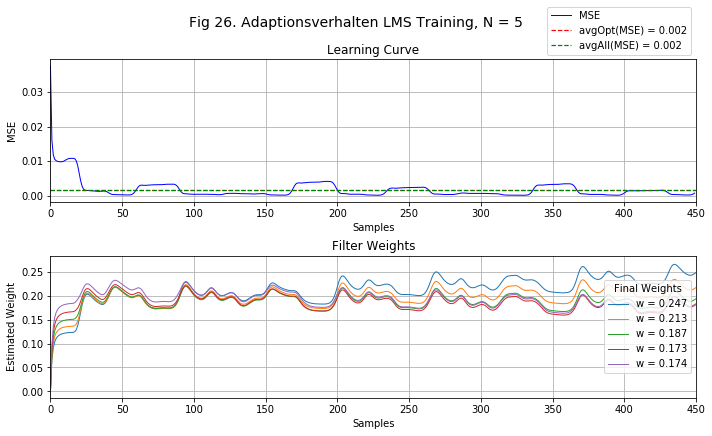

In [27]:
N = 5

E, W, w, Yd = algo.lmsAlg(5, 0.1, traindata, traindata, np.zeros(5), \
                                predict=True) # ! prediction
ts.errorPlot(E, W, 450, 'Fig 26. Adaptionsverhalten LMS Training, N = '\
             +str(N), style='lin',avgFrom=0)

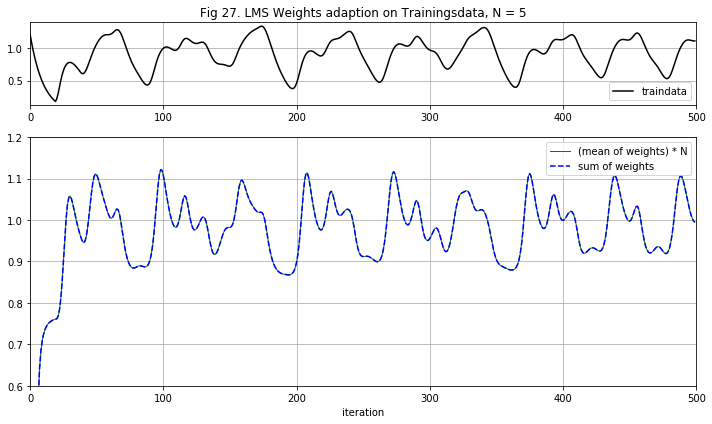

In [28]:
from matplotlib import gridspec

# Calculate mean and sum of weights per iteration
LMSwm = np.mean(W, axis=0)
LMSws = np.sum(W, axis=0)

# Plot
plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
plt.subplot(gs[0])
plt.title('Fig 27. LMS Weights adaption on Trainingsdata, N = '+str(N))
plt.grid(True)
plt.plot(traindata.T, 'k', label='traindata')
plt.xlim([0,500])
plt.legend()

plt.subplot(gs[1])
plt.grid(True)
plt.plot(LMSwm*5, 'g', label='(mean of weights) * N', linewidth=1)
plt.plot(LMSws, 'b--', label='sum of weights')
plt.xlabel('iteration')
plt.ylim([0.6, 1.2])
plt.xlim([0,500])
plt.legend()

plt.tight_layout()

## Fazit

Im Allgemeinen konnten der LMS, RLS mit Vergessensfaktor und KLMS erfolgreich implementiert und erprobt werden. Die Programmierarbeit der Algorithmen war sehr lehrreich und hat mir erlaubt diverse Paradigmen zu erproben. Der Code könnte aufgrund meiner Eprobung mancher Python-Strukturierung erneut einfacher angelegt und mit weniger akademischer Motivation implementiert werden.

Die Entwicklung des Python [3] Skripts mit Spyder [4] gestaltete sich sehr effektiv und ähnelte stark dem Workflow in Matlab, was die Arbeit sehr komfortabel macht. Weniger gut als anfänglich gedacht hat mir die Gestaltung der Dokumentation mit dem Jupyter Notebook [5] gefallen, da die interaktiven Konsolen sehr dazu verleiten zu viele Plots zu verwenden. Letztlich konnte ich mich bei den spannenden Ergebnisses aber auch nicht dazu bewegen die Anzahl zu reduzieren, da ich die Plots in diesem Dokument zur späteren Referenz und der Bildung einer Intuition für diese betrachteten Algorithmen nicht vermissen möchte. Weitergehend wurden Bibliotheken für Algebra, Plot-Darstellung und Numeric von SciPy [6] verwendet.

In Zukunft würde eine Implementierung einer Nested Crossvalidation sinnvoll sein um die Auswahl optimale Parameterisierung der Hyperparameter (Schrittweite, Vergessensfaktor, Bias-Varianz Tradeoff, etc.) automatisiert finden zu können.

### Literaturverzeichnis
[1] Moschytz, G., & Hofbauer, M. (2000). Adaptive Filter. Berlin ua: Springer.

[2] Liu, W., Principe, J. C., & Haykin, S. (2011). Kernel adaptive filtering: a comprehensive introduction (Vol. 57). John Wiley & Sons.

[3] Python (interpreted high-level programming language for general-purpose programming), 2018, https://www.python.org/

[4] Spyder (Scientific PYthon Development EnviRonment), https://www.spyder-ide.org/,  last accessed 29.09.2018

[5] Jupyter (Interactive data science and scientific computing notebook),  http://jupyter.org/,  last accessed 29.09.2018

[6] SciPy (python-based ecosystem of open-source software for mathematics, science, and engineering), 2018, https://www.scipy.org/,  last accessed 29.09.2018